In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from sklearn.model_selection import train_test_split

In [ ]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [ ]:
def parse_and_pad_column(col, maxlen=200):
    vectors = df[col].apply(lambda x: np.array(eval(x)))
    padded = pad_sequences(vectors, maxlen=maxlen, padding='post', dtype='float32')
    return padded

max_len = 200

x1 = parse_and_pad_column("code1_vecMark", maxlen=max_len)
x2 = parse_and_pad_column("code2_vecMark", maxlen=max_len)
y = df["result"].values
splits = df["split"]

x1 = np.expand_dims(x1, axis=-1)
x2 = np.expand_dims(x2, axis=-1)

In [ ]:
x1_train = x1[splits == "train"]
x2_train = x2[splits == "train"]
y_train = y[splits == "train"]

x1_val = x1[splits == "validation"]
x2_val = x2[splits == "validation"]
y_val = y[splits == "validation"]

x1_test = x1[splits == "test"]
x2_test = x2[splits == "test"]
y_test = y[splits == "test"]

In [ ]:
from tensorflow.keras.optimizers import Adam

def build_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(128, 5, activation='relu', padding='same')(input_layer)
    x = GlobalMaxPooling1D()(x)
    return input_layer, x

input_shape = (max_len, 1)
input1, out1 = build_branch(input_shape)
input2, out2 = build_branch(input_shape)

merged = Concatenate()([out1, out2])
x = Dense(128, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 200, 128)  │        768 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 200, 128)  │        768 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,561 (135.00 KB)

 Trainable params: 34,561 (135.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    [x1_train, x2_train], y_train,
    validation_data=([x1_val, x2_val], y_val),
    epochs=200,
    batch_size=32
)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4916 - loss: 0.6961 - val_accuracy: 0.5400 - val_loss: 0.6908
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5170 - loss: 0.6949 - val_accuracy: 0.4700 - val_loss: 0.6947
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5344 - loss: 0.6925 - val_accuracy: 0.6000 - val_loss: 0.6906
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5860 - loss: 0.6910 - val_accuracy: 0.5200 - val_loss: 0.6884
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5357 - loss: 0.6913 - val_accuracy: 0.5300 - val_loss: 0.6889
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5207 - loss: 0.6925 - val_accuracy: 0.5800 - val_loss: 0.6904
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5767 - loss: 0.6893 - val_accuracy: 0.5900 - val_loss: 0.6886
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5987 - loss: 0.6866 - val_accuracy: 0.5300 - 

In [ ]:
loss, accuracy = model.evaluate([x1_test, x2_test], y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6676 - loss: 0.6323 

🔍 Test Accuracy: 0.6300


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


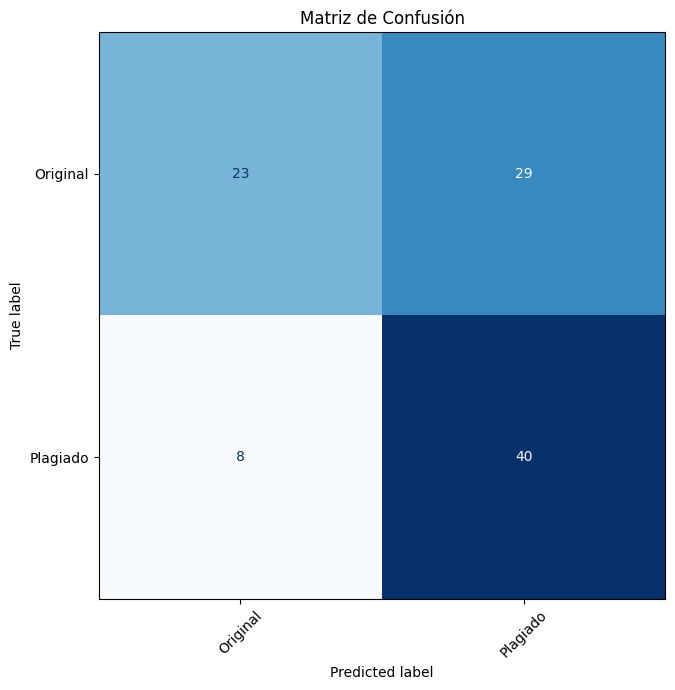


📋 Reporte de clasificación:

              precision    recall  f1-score   support

    Original       0.74      0.44      0.55        52
    Plagiado       0.58      0.83      0.68        48

    accuracy                           0.63       100
   macro avg       0.66      0.64      0.62       100
weighted avg       0.66      0.63      0.62       100



In [ ]:

y_pred = (model.predict([x1_test, x2_test]) > 0.5).astype(int).flatten()
labels = ["Original", "Plagiado"]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
plt.xticks(rotation=45)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=labels))